In [92]:
import numpy as np 
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [93]:
def AddImage(path):
  test_img = Image.open(path)

  test_img = test_img.resize((5,5))
  test_img = test_img.convert('L')
  '''plt.imshow(test_img, cmap = 'gray')
  plt.show()'''

  test_x = np.array(test_img, np.float32)
  test_x = test_x.reshape(-1,25)
  test_x = test_x / 255
  return test_x[0]

In [94]:
def AddGludSmiles(x, y,folderPath):
  for filename in os.listdir(folderPath):
    x.append(AddImage(os.path.join(folderPath, filename)))
    y.append(1)

def AddUglySmiles(x, y,folderPath):
  for filename in os.listdir(folderPath):
    x.append(AddImage(os.path.join(folderPath, filename)))
    y.append(0)

In [95]:
x = []
y = []
AddUglySmiles(x,y,'GludSmiles')
AddGludSmiles(x,y,'UglySmiles')
x = np.array(x)
y = np.array(y)

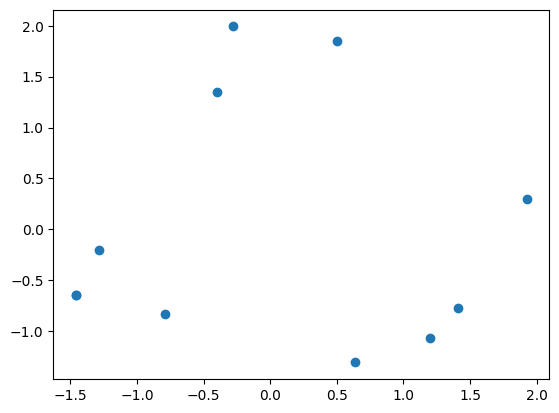

In [96]:
pca = PCA(2)
x_dr = pca.fit_transform(x)

plt.scatter(x_dr[:,0], x_dr[:,1])

In [97]:
def metric(x1,x2):
  return np.sqrt(np.sum((x1-x2)**2))

class KNN:
  def __init__(self, k, x, y) -> None:
      self.K = k
      self.X = x
      self.Y = y
      
  def predict(self, x):
    pred = []
    for i in x:
      dists = np.array([metric(i, x_t) for x_t in self.X]) 
      dists_sort = dists.argsort()[:self.K]
      neigh = {}

      for j in dists_sort:
        target = self.Y[j]
        if target in neigh:
          neigh[target] +=1
        else:
          neigh[target] = 1
    
      pred.append(max(neigh, key = neigh.get))
    return pred
  

In [98]:
def Hebba(weight, x0, y, e, alpha = 0.1):
    #Обучает вес по правилу хебба
    return weight - alpha * x0 * (y - e)
    
def sigmoid(x):
    return 1 if x > 0 else 0

class Neuron:
    def __init__(self, weights, bias =1, biasWigth = 1):
        self.Weights = weights
        self.DeltaWeights = np.zeros(len(weights))
        self.Bias = bias
        self.Beta = 0
        self.BiasWigth = biasWigth
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias * self.BiasWigth
        self.LastRezult = total
        return sigmoid(total)
    
    
    def WeightCorrection(self, function, y, e, alpha = 0.1):
        for i in range(len(self.Weights)):
                self.Weights[i] = function(self.Weights[i], self.LastInput[i], y, e, alpha)
                
        self.BiasWigth = function(self.BiasWigth, self.Bias, y, e,  alpha)


In [99]:
class HebbNetwork:
    def __init__(self, neuronsCountArray, eps = 0.1, alpha = 0.1):
        '''
        neuronsCountArray example [25, 14, 7, 3, 1] where each number mean
         a count of neurons in the layer
        ''' 
        self.Alpha = alpha
        self.Eps = eps
        self.T = 0
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          for j in range(neuronsCountArray[i]):
            self.Neurons[i].append(Neuron(np.random.rand(neuronsCountArray[i-1]), 1)) 
    
    def fit(self, X, y):
        t = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and t < 1000:
            for i in range(len(X)):
                e = self.feedforward(X[i])
                if e != y[i]:
                    self.WeightCorrection(e, y[i])
                    self.CalculateLoss(X,y)
                    t+=1
                if self.L[len(self.L)-1] > self.Eps:
                   break
        print("network was learned for",t,"generations")
        self.T = t
    
    def predict(self, data):
        return self.feedforward(data)
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y[0]

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        if e != y[j]:
          loss +=1
      self.L.append(loss/len(x))
      return loss/len(x)


    def WeightCorrection(self,y,e):
        function = Hebba
        for i in self.Neurons:
          [neuron.WeightCorrection(function,y,e,self.Alpha) for neuron in self.Neurons[i]]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

Trains


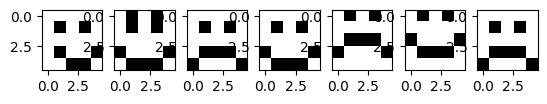

Tests


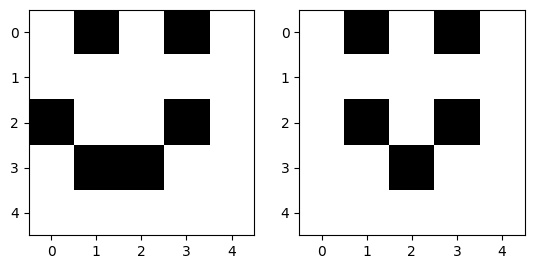

In [101]:
print("Trains")
for i in range(7):
  plt.subplot(1,7, i+1)
  plt.imshow(X_train[i].reshape(5,5), cmap = "gray")
plt.show()
print("Tests")
for i in range(2):
  plt.subplot(1,2, i+1)
  plt.imshow(X_test[i].reshape(5,5), cmap = "gray")

In [102]:

kVals = [1, 3, 5, 7]
for k in kVals:
  knn = KNN(k, X_train, y_train)
  pred = knn.predict(X_test)
  print("k =",k ,'accuracity =', accuracy_score(y_test, pred))

k = 1 accuracity = 0.75
k = 3 accuracity = 0.75
k = 5 accuracity = 0.0
k = 7 accuracity = 0.5


In [104]:
perceptron = HebbNetwork([25, 1], 0.2, 0.4)
perceptron.fit(x,y)
print("testLoss: ",perceptron.CalculateLoss(x, y))
plt.plot(range(1,perceptron.T+1), perceptron.L[:perceptron.T])